In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import io
import pickle
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter, defaultdict

In [2]:
os.chdir('..')

In [3]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [4]:
gauth = GoogleAuth()
gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("mycreds.txt")
drive = GoogleDrive(gauth)

In [5]:
max_games = 500000 
asset_dir = 'asset'
file_name = '2023_tc_500000_games.pgn'
slice = 3

cached_urls_file = file_name.split('.')[0] + f'_urls_list_{slice}.pkl'
cached_ratings_file = file_name.split('.')[0] + f'_ratings_list_{slice}.pkl'
cached_games_file = file_name.split('.')[0] + f'_game_arrays_{slice}.pkl'

In [6]:
def load_item_from_file(file_path):
    if os.path.exists(file_path):
        print('loading item from cache...')
        with open(file_path, 'rb') as file:
            items = pickle.load(file)
        print('loaded')
        return items
    else:
        return None

try:
    assets_path = os.path.join(os.getcwd(), asset_dir)
    cached_urls_path = os.path.join(assets_path, cached_urls_file)
    cached_ratings_path = os.path.join(assets_path, cached_ratings_file)
    cached_games_path = os.path.join(assets_path, cached_games_file)
    urls_list = load_item_from_file(cached_urls_path)
    ratings_list = load_item_from_file(cached_ratings_path)
    game_arrays = load_item_from_file(cached_games_path)
except:
    print('Files not on disk, reading from drive...')
    urls_list = None
    ratings_list = None
    game_arrays = None

loading item from cache...
loaded
loading item from cache...
loaded
loading item from cache...
loaded


In [7]:
def find_folder_id(folder_name):
    file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == folder_name:
            return file['id']
    return None

def read_pkl_file_from_drive(file_title, parent_id):
    query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
    file_list = drive.ListFile({'q': query}).GetList()
    if not file_list:
        print(f"No file found with title: {file_title}")
        return None
    file = file_list[0]
    file_content = file.GetContentString(encoding='cp437')
    buffer = io.BytesIO(file_content.encode('cp437'))
    return pickle.load(buffer)

asset_folder_id = find_folder_id(asset_dir)
if asset_folder_id is None:
    print("Asset folder not found.")
elif game_arrays is not None:
    pass
else:
    file_titles = {
        'urls_list': cached_urls_file,
        'ratings_list': cached_ratings_file,
        'game_arrays': cached_games_file,
    }

    urls_list = read_pkl_file_from_drive(file_titles['urls_list'], asset_folder_id)
    ratings_list = read_pkl_file_from_drive(file_titles['ratings_list'], asset_folder_id)
    game_arrays = read_pkl_file_from_drive(file_titles['game_arrays'], asset_folder_id)

if urls_list is not None:
    print("URLs list loaded successfully.")
if ratings_list is not None:
    print("Ratings list loaded successfully.")
if game_arrays is not None:
    print("Game arrays loaded successfully.")

##2m 26.4s

URLs list loaded successfully.
Ratings list loaded successfully.
Game arrays loaded successfully.


In [8]:
ratings_list = [(r[0]+r[1])//2 for r in ratings_list]
#ratings_list = [r[0] for r in ratings_list]

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc_classification = nn.Linear(hidden_size, num_classes)
        self.fc_regression = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.dropout(F.relu(self.fc3(out)))
        out = self.dropout(F.relu(self.fc4(out)))
        out = self.dropout(F.relu(self.fc5(out)))
        out = self.dropout(F.relu(self.fc6(out)))
        out = self.dropout(F.relu(self.fc7(out)))
        classification_output = self.fc_classification(out)
        regression_output = self.fc_regression(out)
        return classification_output, regression_output

In [10]:
def combined_loss(classification_output, regression_output, target, alpha=0.5):
    classification_loss = nn.CrossEntropyLoss()(classification_output, target)
    regression_target = target.float()
    regression_loss = nn.MSELoss()(regression_output.squeeze(), regression_target)
    return alpha * classification_loss + (1 - alpha) * regression_loss

def train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha=0.5):
    torets = []
    for epoch in range(num_epochs):
        model.train()
        for i, (moves, labels) in enumerate(train_loader):  
            moves = moves.to(device)
            labels = labels.to(device)

            classification_output, regression_output = model(moves)
            loss = combined_loss(classification_output, regression_output, labels, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
        pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
        toret = [x/20000 for x in pred_closeness]
        torets.append(toret)
    return torets

def test_model(model, test_loader, device):
    model.eval()
    n_correct = 0
    n_samples = 0
    predicted_probs = []
    predicted_labels = []
    actual_labels = []
    with torch.no_grad():
        for moves, labels in test_loader:
            moves = moves.to(device)
            labels = labels.to(device)
            classification_output, _ = model(moves)
            probabilities = F.softmax(classification_output, dim=1)

            _, predicted = torch.max(classification_output.data, 1)
            predicted_probs.extend(probabilities.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test moves: {acc} %')
    return predicted_probs, predicted_labels, actual_labels

In [11]:
def pad_game(game, max_length=256, vector_size=42):
    padding_length = max_length - len(game)
    if padding_length < 0:
        return game[:max_length]
    else:
        padding = np.full((padding_length, vector_size), -1)
        return np.vstack((game, padding))

In [12]:
def get_loaders(padded_games, ratings_list, urls_list, batch_size, fold_number=0):
    if fold_number < 0 or fold_number > 4:
        raise ValueError("fold_number must be between 0 and 4")
    test_list = padded_games[fold_number::5]
    #print(len(test_list))
    train_list = [df for i in range(5) if i != fold_number for df in padded_games[i::5]]
    test_ratings = ratings_list[fold_number::5]
    train_ratings = [ratings for i in range(5) if i != fold_number for ratings in ratings_list[i::5]]
    test_urls = urls_list[fold_number::5]
    train_urls = [url for i in range(5) if i != fold_number for url in urls_list[i::5]]

    train_data = [torch.FloatTensor(doc) for doc in train_list]
    test_data = [torch.FloatTensor(doc) for doc in test_list]
    train_labels = torch.LongTensor(train_ratings)
    test_labels = torch.LongTensor(test_ratings)

    train_dataset = TensorDataset(torch.stack(train_data), train_labels)
    test_dataset = TensorDataset(torch.stack(test_data), test_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_urls, test_urls

In [13]:
input_size = 42
num_classes = 10

num_epochs = 40
sequence_length = 128
batch_size = 100
hidden_size = 100
num_layers = 3
learning_rate = 0.0008
alpha = 0.9
dropout_rate = 0
decay = 0.0001

torch.manual_seed(64)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = file_name.split('.')[0] + '_pred.pth'
model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

def train_lstm():
    padded_games = [pad_game(g, sequence_length) for g in game_arrays]
    lstm_preds = []
    lstm_truths = []
    lstm_probs = []
    for fold in range(5):
        print(f"Training Epoch {fold+1}/5 ...")
        train_loader, test_loader, train_urls, test_urls = get_loaders(padded_games, ratings_list, urls_list, batch_size, fold)
        model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        lists = train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha)
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)

        lstm_probs.append(predicted_probs)
        lstm_preds.append(predicted_labels)
        lstm_truths.append(actual_labels)
    return lstm_probs, lstm_preds, lstm_truths

The model has 291,011 trainable parameters


In [15]:
#lstm_probs_l, lstm_preds_l, lstm_truths_l = train_lstm()

In [16]:
def load_path_run():
    input_size = 42
    num_classes = 10

    sequence_length = 128
    batch_size = 100
    hidden_size = 100
    num_layers = 3
    learning_rate = 0.0008
    alpha = 0.9
    dropout_rate = 0
    decay = 0.0001
    torch.manual_seed(42)

    model_path = '2023_tc_50000_games_pred.pth'
    #model_path = '2023_tc_500000_games_pred_0.125.pth'
    #model_path = '2023_tc_500000_games_pred_0.25.pth'
    padded_games = [pad_game(g, sequence_length) for g in game_arrays]
    lstm_probs = []
    lstm_preds = []
    lstm_truths = []

    for fold in range(5):
        print(f"Testing Epoch {fold+1}/5 ...")
        train_loader, test_loader, train_urls, test_urls = get_loaders(padded_games, ratings_list, urls_list, batch_size, fold)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'The model has {num_params:,} trainable parameters')

        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)

        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)

        pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
        print([x/len(predicted_labels) for x in pred_closeness])

        lstm_probs.extend(predicted_probs)
        lstm_preds.extend(predicted_labels)
        lstm_truths.extend(actual_labels)
    return lstm_probs, lstm_preds, lstm_truths

In [17]:
lstm_preds_path = 'lstm_test_preds.pkl'
lstm_truths_path = 'lstm_test_truths.pkl'
lstm_probs_path = 'lstm_test_probs.pkl'

try:
    with open(lstm_preds_path, 'rb') as file:
        lstm_preds_l = pickle.load(file)
    with open(lstm_truths_path, 'rb') as file:
        lstm_truths_l = pickle.load(file)
    with open(lstm_probs_path, 'rb') as file:
        lstm_probs_l = pickle.load(file)
    print("Successfully loaded LSTM configurations!")

except:
    lstm_probs_l, lstm_preds_l, lstm_truths_l = train_lstm()   
    with open(lstm_preds_path, 'wb') as file:
        pickle.dump(np.array(lstm_preds_l), file)
    with open(lstm_truths_path, 'wb') as file:
        pickle.dump(np.array(lstm_truths_l), file)
    with open(lstm_probs_path, 'wb') as file:
        pickle.dump(np.array(lstm_probs_l), file)
        
a,b,c,d,e = lstm_probs_l
lstm_probs = [*a,*b,*c,*d,*e]
a,b,c,d,e = lstm_preds_l
lstm_preds = [*a,*b,*c,*d,*e]
a,b,c,d,e = lstm_truths_l
lstm_truths = [*a,*b,*c,*d,*e]

Successfully loaded LSTM configurations!


In [18]:
sum([l==m for (l,m) in zip(lstm_preds, lstm_truths)])

33218

In [19]:
label_count_mat = np.zeros((10, 10))
np.add.at(label_count_mat, (np.array(lstm_truths), np.array(lstm_preds)), 1)

label_prob_mat = []
for label in range(10):
    mask = np.array(lstm_truths) == label
    probs = np.array([p for p,masking in zip(lstm_probs,mask) if masking]).mean(axis=0)
    label_prob_mat.append(probs)
label_prob_mat = np.array(label_prob_mat)

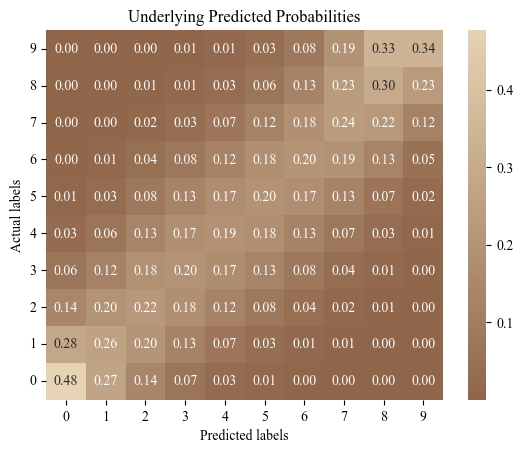

In [20]:
darkest_hex = "#90664b"
lightest_hex = "#e5d3b3"
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", [darkest_hex, lightest_hex])

ax = sns.heatmap(label_prob_mat[::-1], annot=True, cmap=custom_cmap, fmt=".2f")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Underlying Predicted Probabilities")

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, verticalalignment='center', fontsize="10")
ax.set_yticklabels(range(9, -1, -1), rotation=0, verticalalignment='center')

plt.show()

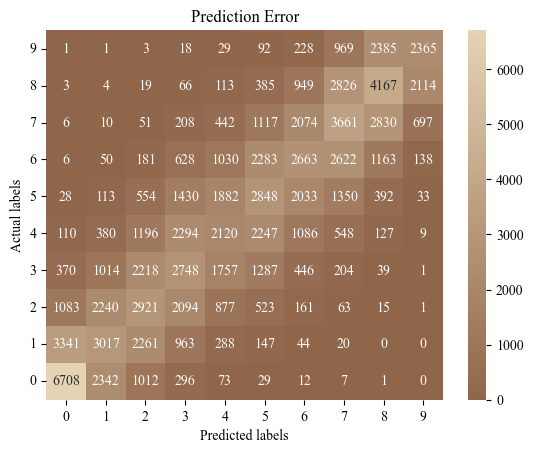

In [21]:
ax = sns.heatmap(label_count_mat[::-1], annot=True, cmap=custom_cmap, fmt=".0f")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Prediction Error")

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, verticalalignment='center', fontsize="10")
ax.set_yticklabels(range(9, -1, -1), rotation=0, verticalalignment='center')

plt.show()

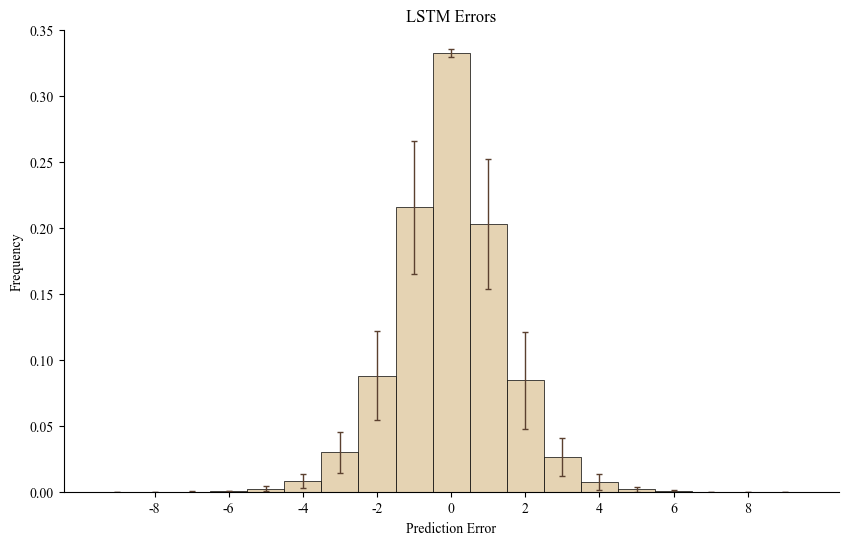

In [22]:
def pred_and_truth_to_dict(diffs, accums):
    errordict = defaultdict(float)
    for diff, accum in zip(diffs, accums):
        errordict[diff] += accum
    categories = range(-9, 10)
    errordict = {n: errordict[n] for n in categories}
    frequencies = list(errordict.values())
    return frequencies

def plot_errors(ax, frequencies, title, std_dev=None):
    categories = list(range(-9, 10, 1))
    ax.bar(categories, frequencies, width=1, color='#e5d3b3', edgecolor='black', linewidth=0.5) 
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(-8, 9, 2))
    ax.set_xticklabels(range(-8, 9, 2))
    ax.set_ylim(bottom=0, top=0.35)

    if std_dev is not None:
        n = np.array(frequencies)
        n[n == 0] = np.nan
        ci_95 = 1.96 * np.array(std_dev) #math checks out
        ax.errorbar(categories, frequencies, yerr=ci_95, fmt='none', ecolor='#5b402f', capsize=2, elinewidth=1)

def pred_and_test_mat_to_freqs(them_preds, them_tests):
    length = 20000
    increments = [1/length]*length
    n_by_error_l = []
    for i in range(len(them_preds)):
        y_pred = them_preds[i]
        y_test = them_tests[i]
        increments = [1/2e4]*length
        edict = [p-a for p, a in zip(y_pred, y_test)]
        n_by_error = pred_and_truth_to_dict(edict, increments)
        n_by_error_l.append(n_by_error)
    frequencies = np.mean(np.array(n_by_error_l), axis=0)
    standard_errors = np.std(np.array(n_by_error_l), axis=0)
    return frequencies, standard_errors

fig, ax = plt.subplots(figsize=(10, 6))
frequencies_lstm, standard_errors_lstm = pred_and_test_mat_to_freqs(lstm_preds_l, lstm_truths_l)
plot_errors(ax, frequencies_lstm, 'LSTM Errors', standard_errors_lstm)

plt.show()

In [24]:
standard_errors_lstm[9]

0.001495526663085452

In [25]:
for f in [frequencies_lstm]:
    accuracies = [0]*10
    for p, i in zip(f, range(-9, 10, 1)):
        accuracies[abs(i)] += p
    accs = [round(20000*sum(accuracies[:i+1])) for i in range(len(accuracies))]
    print([round(i/200, 2) for i in accs])

[33.22, 75.06, 92.28, 97.9, 99.47, 99.87, 99.97, 100.0, 100.0, 100.0]
